### Import the necessary packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import prince
from sklearn.metrics import confusion_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

### Read in the data

In [2]:
df = pd.read_csv('diabetic_data.csv')

### Fix various issues with the variables

In [3]:
#Replace "?" values with nan since these are missing values
df.replace('?',np.nan,inplace=True)
#Drop rows where we don't have race since it's a relatively small amount
df.dropna(inplace=True,subset = ['race'])
#Remove all rows where gender is unknown since there's so few
df = df[df['gender']!='Unknown/Invalid']
#Relevel the readmitted variable so that it becomes a binary question of readmitted or not
readmitted_dict = {'NO':0, '<30':1,'>30':1}
df['readmitted'] = df['readmitted'].map(readmitted_dict)
#Relevel the race variable to condense the uncommon levels into the "Other" level
race_dict = {'Caucasian':'Caucasian','AfricanAmerican':'AfricanAmerican','Hispanic':'Other','Other':'Other','Asian':'Other'}
df['race'] = df['race'].map(race_dict)
#Get dummy variables for gender and race
df = pd.get_dummies(df,columns=['gender','race'],drop_first=True)
#Relevel the drug columns from metformin to metformin-pioglitazone to be 0 if they are not on the drug and 1 if they are
for col in df.loc[:,'metformin':'metformin-pioglitazone']:
    df[col] = df[col].map({'No':'No','Steady':'Yes','Up':'Yes','Down':'Yes'})

### Examine correlations between the variables

Text(0.5, 1.0, 'Correlation Heatmap')

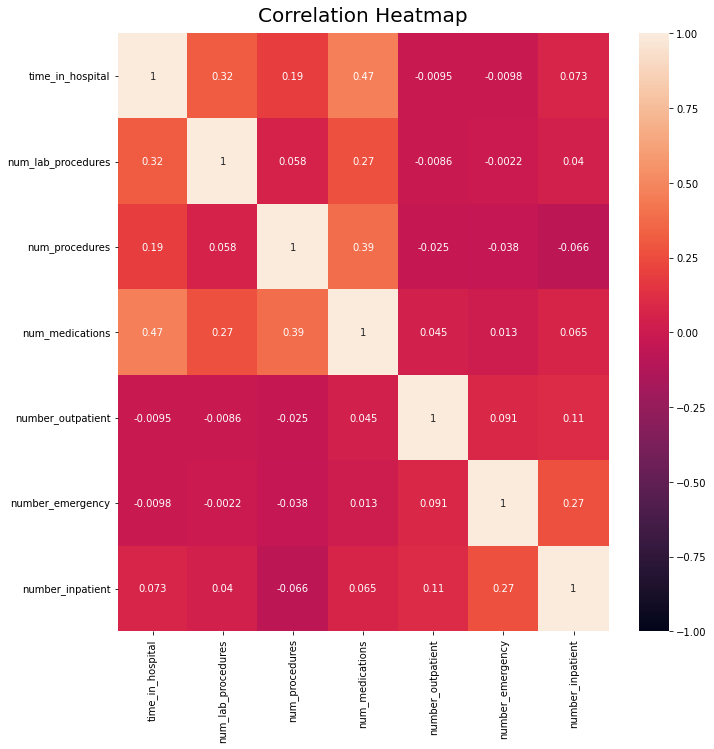

In [4]:
#Get only quantitative columns to compute correlations of
df_quant = df[['time_in_hospital','num_lab_procedures','num_procedures','num_medications','number_outpatient','number_emergency','number_inpatient']]
#Compute correlations between these quantitative variables and output a heatmap
corr = df_quant.corr()
plt.figure(figsize=(11, 11))
heatmap = sns.heatmap(corr,
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values,vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=12)

### Splitting into train and test sets

In [5]:
#Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df.drop(['readmitted'],axis=1),df['readmitted'],test_size=0.25,random_state=1)
#Getting the quantitative variables
X_train_quant = X_train.loc[:, df_quant.columns]

### Seeing if we should be removing outliers

In [6]:
from pyod.models.knn import KNN
clf = KNN()
#Fit the model using training data
clf.fit(X_train_quant)
#Get the outlier scores for the training data
outlier_pred = clf.predict(X_train_quant)
#Add the outlier column to the quantitative training data
X_train_quant['outlier'] = outlier_pred
#See which rows are outliers to make sure that they aren't entry errors
X_train_quant[X_train_quant['outlier']==1]

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,outlier
96688,5,43,2,32,0,3,2,1
3877,8,61,6,9,0,0,0,1
44835,9,19,3,14,0,0,3,1
18240,3,43,1,21,1,0,7,1
34302,7,12,5,23,0,0,0,1
...,...,...,...,...,...,...,...,...
97635,1,30,6,7,4,0,0,1
32869,9,17,6,17,0,1,0,1
94806,5,5,0,13,4,0,1,1
22109,6,82,3,22,0,0,3,1


### Trying out PCA - Quantitative Variables

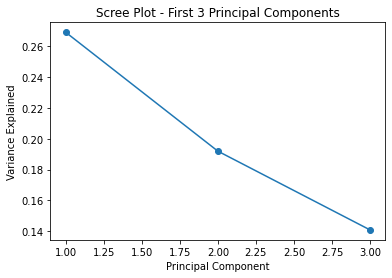

Variance Explained by First 3 Principal Components:  0.6020847750912953


In [7]:
#Drop the outlier column after we displayed it above
X_train_quant.drop('outlier',axis=1,inplace=True)
#Standardizing the quantitative variables
X_train_quant_scaled = pd.DataFrame(StandardScaler().fit_transform(X_train_quant))
#Establishing the number of principle components to create and actually creating them
pca = PCA(n_components=3)
pr_comp = pca.fit_transform(X_train_quant_scaled)
#Store results in a data frame and add the response variable
df_pca = pd.DataFrame(pr_comp ,columns = ['PC1', 'PC2','PC3'])
df_pca['readmitted'] = y_train.values
#Make a scree plot to see how much variance is explained by each principal component
num_pc = [i for i in range(1,pca.n_components_+1)]
plt.plot(num_pc, pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot - First 3 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()
print('Variance Explained by First 3 Principal Components: ',sum(pca.explained_variance_ratio_))

Text(0.5, 1.0, 'Readmitted Distribution by Principal Components')

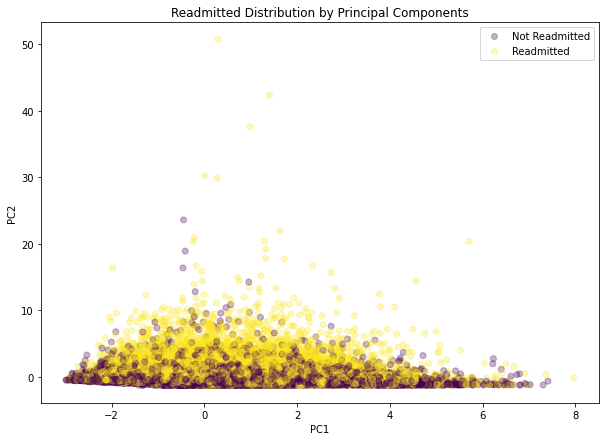

In [8]:
#Plot the scores on the first two principal components and color by the readmitted variable to see how well the principal components
#separate the classes
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_pca['PC1'],df_pca['PC2'],c=df_pca['readmitted'],alpha=0.3)
plt.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Readmitted Distribution by Principal Components')

In [9]:
X_train_quant.describe()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient
count,74619.000000,74619.000000,74619.000000,74619.000000,74619.000000,74619.000000,74619.000000
mean,4.394605,43.089669,1.339270,16.020317,0.378349,0.202107,0.642718
std,2.979510,19.702287,1.701383,8.116880,1.291789,0.957029,1.265939
min,1.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,31.000000,0.000000,10.000000,0.000000,0.000000,0.000000
50%,4.000000,44.000000,1.000000,15.000000,0.000000,0.000000,0.000000
75%,6.000000,57.000000,2.000000,20.000000,0.000000,0.000000,1.000000
max,14.000000,132.000000,6.000000,81.000000,42.000000,76.000000,21.000000


In [10]:
#add the principal components to the training data
X_train_quant['PC1'] = df_pca['PC1']
X_train_quant.corr()

,time_in_hospital,num_lab_procedures,num_procedures,num_medications,number_outpatient,number_emergency,number_inpatient,PC1
time_in_hospital,1.000000,0.316731,0.193196,0.465025,-0.009152,-0.008643,0.076241,-0.006886
num_lab_procedures,0.316731,1.000000,0.056574,0.264797,-0.007515,0.000420,0.042686,0.001966
num_procedures,0.193196,0.056574,1.000000,0.387900,-0.023892,-0.038458,-0.066273,-0.001224
num_medications,0.465025,0.264797,0.387900,1.000000,0.044306,0.013789,0.065038,-0.001071
number_outpatient,-0.009152,-0.007515,-0.023892,0.044306,1.000000,0.091233,0.107149,0.003400
number_emergency,-0.008643,0.000420,-0.038458,0.013789,0.091233,1.000000,0.265381,-0.000153
number_inpatient,0.076241,0.042686,-0.066273,0.065038,0.107149,0.265381,1.000000,-0.001696
PC1,-0.006886,0.001966,-0.001224,-0.001071,0.003400,-0.000153,-0.001696,1.000000


In [19]:
#Add the three principal components to the training data
X_train['PC1'] = df_pca['PC1'].values
X_train['PC2'] = df_pca['PC2'].values
X_train['PC3'] = df_pca['PC3'].values

Text(0.5, 0.92, 'Readmitted Distribution by Principal Components')

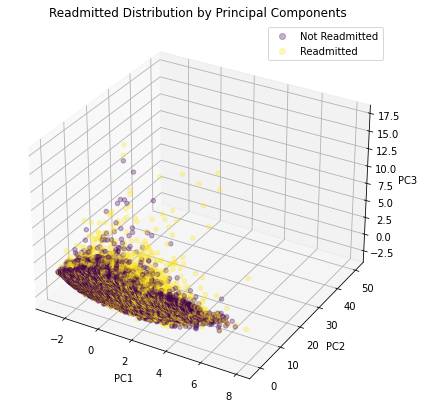

In [12]:
#Plot the scores on the first three principal components and color by the readmitted variable to see how well the principal components
#separate the classes
ax = plt.figure(figsize=(10, 7)).gca(projection='3d')
scatter = ax.scatter(xs=df_pca['PC1'], ys=df_pca['PC2'], zs=df_pca['PC3'], c=df_pca['readmitted'],alpha=0.3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'])
plt.title('Readmitted Distribution by Principal Components')

Text(0.5, 0, 'Readmitted')

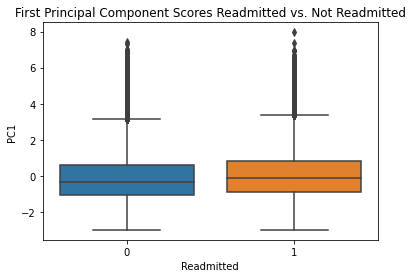

In [13]:
#Make a box plot comparing the readmitted and not readmitted groups for the first principal component
sns.boxplot(x=df_pca['readmitted'],y=df_pca['PC1'])
plt.title('First Principal Component Scores Readmitted vs. Not Readmitted')
plt.xlabel('Readmitted')

### Trying out t-SNE - Quantitative Variables

In [14]:
#Get two t-SNE components with perplexity of 10
tsne = TSNE(n_components=2, perplexity=10, n_iter=250)
tsne_results = tsne.fit_transform(X_train_quant_scaled)

C:\Users\amcre\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\amcre\AppData\Roaming\Python\Python38\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Text(0.5, 1.0, 'Readmitted Distribution by t-SNE Components')

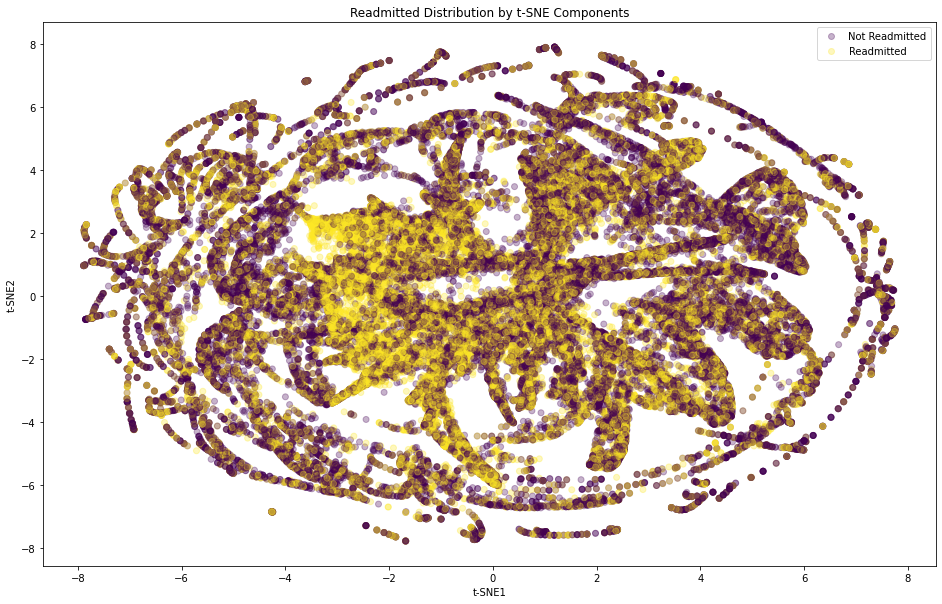

In [15]:
#Set up a data frame with the target variable
df_tsne = pd.DataFrame(y_train)
#Add the two t-SNE components to the data frame
df_tsne['t-SNE1'] = tsne_results[:,0]
df_tsne['t-SNE2'] = tsne_results[:,1]

#Plot the two t-SNE components and color by the readmitted variable to see how well the t-SNE components separate the classes
plt.figure(figsize=(16,10))
scatter = plt.scatter(df_tsne['t-SNE1'],df_tsne['t-SNE2'],c=df_tsne['readmitted'],alpha=0.3)
plt.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'])
plt.xlabel('t-SNE1')
plt.ylabel('t-SNE2')
plt.title('Readmitted Distribution by t-SNE Components')

### Trying out LDA

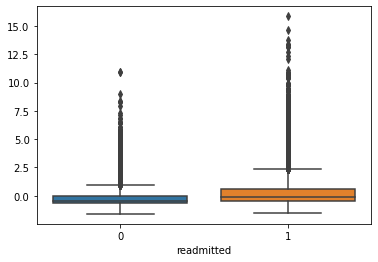

In [16]:
#Set up LDA model
lda = LinearDiscriminantAnalysis()
#Fit the model to the quantitative variables with the readmitted variable being the class to try to separate on
lda.fit(X_train_quant_scaled,y_train)
#Apply the model to the quantitative variables
lda_scores = lda.transform(X_train_quant_scaled)
#Make a boxplot of the transformed data faceted by the readmitted variable
sns.boxplot(x=y_train,y=lda_scores[:,0],data=df)
df_lda = pd.DataFrame(lda_scores,columns=['LDA1'])
df_lda['readmitted'] = df['readmitted']

In [17]:
#find correlation between the LDA1 variable and the readmitted variable
df_lda.corr()

,LDA1,readmitted
LDA1,1.000000,0.004694
readmitted,0.004694,1.000000


### Trying clustering

In [18]:
#do kmeans clustering on df_quant
clusters = KMeans(n_clusters=3, random_state=0).fit(X_train_quant_scaled)
#add the cluster labels to the data frame
X_train_quant_scaled['cluster'] = clusters.labels_
print(pd.crosstab(X_train_quant_scaled['cluster'],y_train))

readmitted      0      1
cluster                 
0            7748   7200
1            2221   2113
2           18477  17052


### Trying MCA - Drugs Columns

Text(0.5, 1.0, 'Readmitted Distribution by MCA Components')

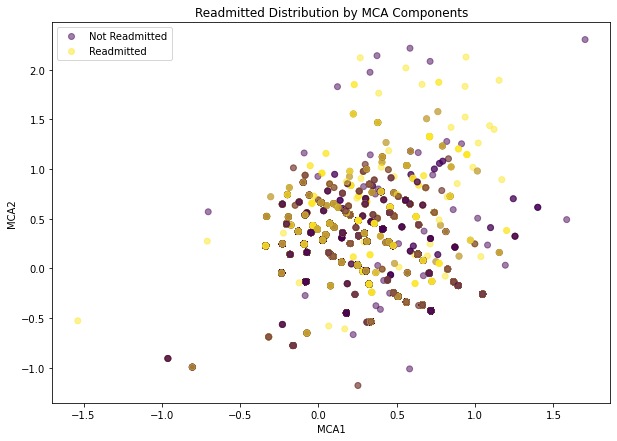

In [19]:
#Get just the columns corresponding to whether a particular drug was prescribed or not
df_drugs = X_train.loc[:,'metformin':'insulin']
#Do MCA on the drugs columns
mca = prince.MCA(n_components = 3, random_state = 1)
mca = mca.fit(df_drugs)
mca = mca.transform(df_drugs)
#Rename the columns
mca.columns = ['MCA1','MCA2','MCA3']
#Add the target variable to the data frame
mca['readmitted'] = y_train
#Plot the first two MCA components colored by the readmitted variable
plt.figure(figsize=(10, 7))
scatter = plt.scatter(mca['MCA1'],mca['MCA2'],c=mca['readmitted'],alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'])
plt.xlabel('MCA1')
plt.ylabel('MCA2')
plt.title('Readmitted Distribution by MCA Components')

Text(0.5, 0.92, 'Readmitted Distribution by MCA Components')

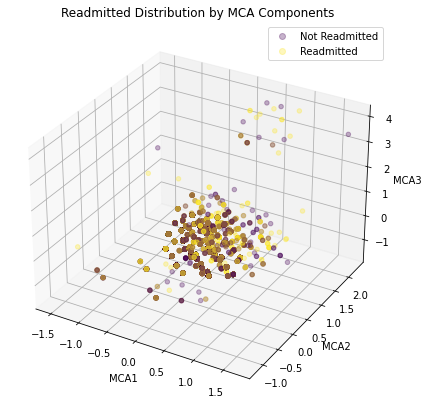

In [20]:
#Plot the scores on the first three MCA components and color by the readmitted variable to see how well the MCA components
#separate the classes
ax = plt.figure(figsize=(10, 7)).gca(projection='3d')
scatter = ax.scatter(xs=mca['MCA1'], ys=mca['MCA2'], zs=mca['MCA3'], c=mca['readmitted'],alpha=0.3)
ax.set_xlabel('MCA1')
ax.set_ylabel('MCA2')
ax.set_zlabel('MCA3')
ax.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'])
plt.title('Readmitted Distribution by MCA Components')

### Trying PCA - Drugs Columns

In [21]:
#For each column in df_drugs, turn "no" to 0 and "yes" to 1 since PCA won't accept strings
for col in df_drugs.columns:
    df_drugs[col] = df_drugs[col].replace('No',0)
    df_drugs[col] = df_drugs[col].replace('Yes',1)

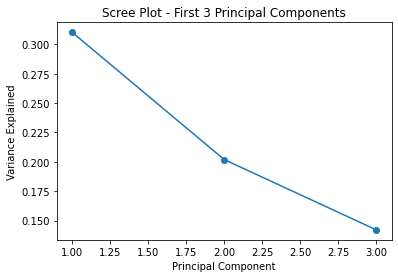

Variance Explained by First 3 Principal Components:  0.6543286560193757


In [22]:
#Establishing the number of principle components to create and actually creating them
pca = PCA(n_components=3)
pr_comp = pca.fit_transform(df_drugs)
#Store results in a data frame and add the response variable
df_pca = pd.DataFrame(pr_comp ,columns = ['PC1', 'PC2','PC3'])
df_pca['readmitted'] = y_train.values
#Plot the principal components and color by the readmitted variable to see how well the principal components
#separate the classes
#Make a scree plot to see how much variance is explained by each principal component
num_pc = [i for i in range(1,pca.n_components_+1)]
plt.plot(num_pc, pca.explained_variance_ratio_, 'o-')
plt.title('Scree Plot - First 3 Principal Components')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()
print('Variance Explained by First 3 Principal Components: ',sum(pca.explained_variance_ratio_))

Text(0.5, 1.0, 'Readmitted Distribution by PCA Components')

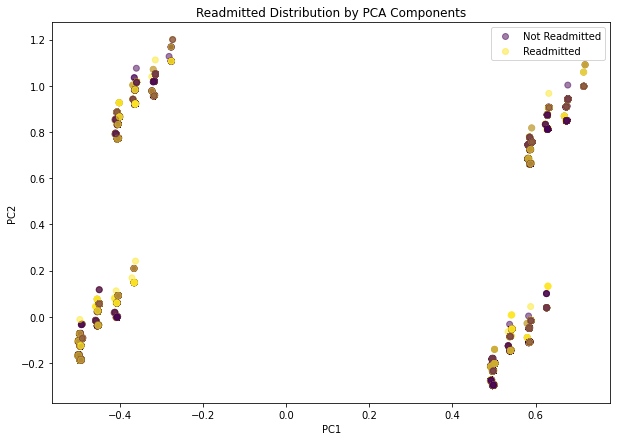

In [23]:
#Plot the first two PCA components colored by the readmitted variable
plt.figure(figsize=(10, 7))
scatter = plt.scatter(df_pca['PC1'],df_pca['PC2'],c=df_pca['readmitted'],alpha=0.5)
plt.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Readmitted Distribution by PCA Components')

Text(0.5, 0.92, 'Readmitted Distribution by PCA Components')

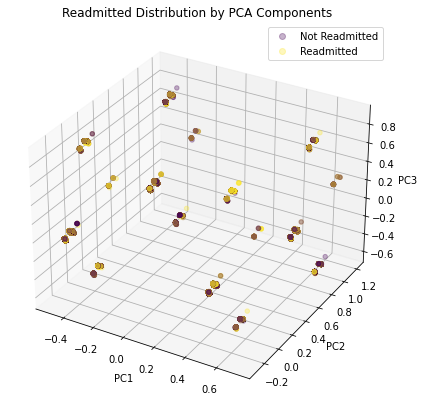

In [24]:
#Plot the scores on the first three MCA components and color by the readmitted variable to see how well the MCA components
#separate the classes
ax = plt.figure(figsize=(10, 7)).gca(projection='3d')
scatter = ax.scatter(xs=df_pca['PC1'], ys=df_pca['PC2'], zs=df_pca['PC3'], c=df_pca['readmitted'],alpha=0.3)
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
ax.legend(handles=scatter.legend_elements()[0], labels=['Not Readmitted','Readmitted'])
plt.title('Readmitted Distribution by PCA Components')

In [25]:
#See how correlated the created principal components are with the target variable
df_pca.corr()

,PC1,PC2,PC3,readmitted
PC1,1.000000e+00,-4.518079e-15,1.359071e-15,-0.045016
PC2,-4.518079e-15,1.000000e+00,2.332070e-16,-0.014082
PC3,1.359071e-15,2.332070e-16,1.000000e+00,0.019121
readmitted,-4.501638e-02,-1.408161e-02,1.912053e-02,1.000000


## Beginning of Model Fitting

### Random Forest - No Cost Consideration

In [28]:
X_test

,encounter_id,patient_nbr,age,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,medical_specialty,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,gender_Male,race_Caucasian,race_Other
80278,247310154,41680350,[80-90),NaN,3,1,1,2,SP,NaN,...,No,No,No,No,No,No,Yes,1,1,0
24566,83142330,18440568,[40-50),NaN,1,1,7,14,NaN,Psychiatry,...,No,No,No,No,No,Ch,Yes,1,1,0
14905,57684636,49023,[70-80),NaN,1,18,7,6,NaN,NaN,...,No,No,No,No,No,No,No,0,1,0
58934,166375614,24140052,[80-90),NaN,1,22,7,4,NaN,InternalMedicine,...,No,No,No,No,No,Ch,Yes,0,0,0
21081,73730532,2216610,[30-40),NaN,1,1,7,6,NaN,NaN,...,No,No,No,No,No,Ch,Yes,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21266,74214618,5793453,[80-90),NaN,1,3,7,13,NaN,NaN,...,No,No,No,No,No,No,No,1,1,0
844,6620760,704430,[50-60),NaN,6,25,7,7,NaN,InternalMedicine,...,No,No,No,No,No,No,Yes,0,1,0
67674,190184976,86283603,[60-70),NaN,1,1,7,2,HM,NaN,...,No,No,No,No,No,No,No,1,1,0
95580,363712766,93242295,[80-90),NaN,2,3,5,3,MC,Emergency/Trauma,...,No,No,No,No,No,Ch,Yes,0,1,0


In [33]:
#fit a random forest model to the data
rf = RandomForestClassifier(n_estimators=200, max_depth=2,random_state=1)
rf.fit(X_train[['race_Caucasian','race_Other','gender_Male']],y_train)
#Get confusion matrix for the model
y_pred = rf.predict(X_test[['race_Caucasian','race_Other','gender_Male']])
confusion_matrix(y_test, y_pred)


array([[13339,     0],
       [11534,     0]], dtype=int64)

In [34]:
#fit a random forest model to the data
rf = RandomForestClassifier(n_estimators=200, max_depth=2,random_state=1,class_weight={0:1,1:5})
rf.fit(X_train[['race_Caucasian','race_Other','gender_Male']],y_train)
#Get confusion matrix for the model
y_pred = rf.predict(X_test[['race_Caucasian','race_Other','gender_Male']])
confusion_matrix(y_test, y_pred)

array([[    0, 13339],
       [    0, 11534]], dtype=int64)

In [26]:
# df_weight_valid = df[df['weight'].notnull()&df['race'].notnull()]
# df_weight_valid = pd.get_dummies(df_weight_valid,columns=['race','gender'])
# weight_dict = {'[0-25)':0,'[25-50)':0, '[50-75)':0,'[75-100)':0,'[100-125)':1,'[125-150)':1,'[150-175)':1,'[175-200)':1,'>200':1,np.nan:np.nan}
# df_weight_valid['weight'] = df_weight_valid['weight'].map(weight_dict)
# df_weight_valid.iloc[:,-6:]
# X = df_weight_valid.iloc[:,-6:]
# y = df_weight_valid['weight']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15,stratify=y)

In [27]:
# #Set up a dictionary to store the accuracy for different values of k
# knn_results = []
# #Loop through a variety of values for k number of neighbors
# for k in range(1,20):
#     knn = KNeighborsClassifier(n_neighbors=k)
#     scores = cross_val_score(knn, X, y, cv=5, scoring='accuracy')
#     knn_results.append(scores.mean())
# #Plot the results
# plt.plot(range(1,20), knn_results)
# plt.xlabel('Value of k')
# plt.ylabel('Cross-Validation Accuracy')
# plt.title('Cross-Validation Accuracy vs. k')
# plt.show()

In [28]:
# knn_final = KNeighborsClassifier(n_neighbors = 4)
# knn_final.fit(X_train,y_train)
# knn_final_pred = knn_final.predict(X_test)
# knn_final.score(X_test,y_test)

In [29]:
# n_estimators = [100,150,200,250,300] 
# max_depth = [2,3,4,5,6] 
# grid = {'n_estimators': n_estimators, 'max_depth': max_depth}
# rf_mod_tuned = RandomForestClassifier(random_state=1)
# #Since we're doing cross validation, combine the training and validation data
# rf_mod_tuned = GridSearchCV(estimator = rf_mod_tuned, param_grid = grid,
#                cv = 5, verbose=2, n_jobs = -1)
# rf_mod_tuned_fitted = rf_mod_tuned.fit(X_train,y_train)
# rf_mod_tuned_pred = rf_mod_tuned_fitted.predict(X_test)
# rf_mod_tuned_fitted.score(X_test,y_test)

In [30]:
# df = pd.get_dummies(df,columns=['race','gender'])
# df['weight'] = df['weight'].map(weight_dict)
# df_test = df[df['weight'].isna()]
# df_train = df.dropna()
# # X_train = df_train[:,-6:]
# # y_train = df_train['weight']
# # X_test = df_test[:-6:]
# # df_weight_valid.iloc[:,-6:]
# # X = df_weight_valid.iloc[:,-6:]
# # y = df_weight_valid['weight']
# # X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=15,stratify=y)

In [31]:
X = df[['gender_Male','race_Caucasian','race_Other']]
y = df['readmitted']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [32]:
train_all = pd.concat([X_train, y_train], axis=1)
m1 = smf.logit(
  formula='readmitted~gender_Male+race_Caucasian+race_Other',
  data=train_all) \
.fit()

m1.summary()

Optimization terminated successfully.
         Current function value: 0.690019
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                79593
Model:                          Logit   Df Residuals:                    79589
Method:                           MLE   Df Model:                            3
Date:                Sun, 27 Nov 2022   Pseudo R-squ.:               0.0008531
Time:                        09:27:17   Log-Likelihood:                -54921.
converged:                       True   LL-Null:                       -54968.
Covariance Type:            nonrobust   LLR p-value:                 3.369e-20
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1364      0.017     -7.956      0.000      -0.170      -0.103
gender_Male       -0.0803      0.014     -5.616      0.000      -0.108      -0.052
race_Caucasian     0.0522      0.018      2.874      0.004       0.017       0.088
race_Other        -0.2228      0.039     -5.757      0.000      -0.299      -0.147
==================================================================================
"""

In [33]:
m2 = smf.logit(
  formula='readmitted~PC1+PC2+PC3+PC4',
  data=final_df_pca) \
.fit()

m2.summary()

NameError: name 'final_df_pca' is not defined

In [ ]:
m3 = smf.logit(
  formula='readmitted~LDA1',
  data=df_lda) \
.fit()

m3.summary()

Optimization terminated successfully.
         Current function value: 0.690857
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                97287
Model:                          Logit   Df Residuals:                    97285
Method:                           MLE   Df Model:                            1
Date:                Tue, 22 Nov 2022   Pseudo R-squ.:               1.727e-05
Time:                        15:45:00   Log-Likelihood:                -67211.
converged:                       True   LL-Null:                       -67213.
Covariance Type:            nonrobust   LLR p-value:                    0.1276
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1352      0.006    -21.032      0.000      -0.148      -0.123
LDA1           0.0095      0.006      1.524      0.127      -0.003       0.022
==============================================================================
"""

In [ ]:
m3 = smf.logit(
  formula='readmitted~time_in_hospital+num_lab_procedures+num_procedures+num_medications+number_outpatient+number_emergency+number_inpatient',
  data=df) \
.fit()

m3.summary()

Optimization terminated successfully.
         Current function value: 0.658512
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                99492
Model:                          Logit   Df Residuals:                    99484
Method:                           MLE   Df Model:                            7
Date:                Tue, 08 Nov 2022   Pseudo R-squ.:                 0.04642
Time:                        12:50:38   Log-Likelihood:                -65517.
converged:                       True   LL-Null:                       -68706.
Covariance Type:            nonrobust   LLR p-value:                     0.000
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.6553      0.019    -34.844      0.000      -0.692      -0.618
time_in_hospital       0.0179      0.003      7.020      0.000       0.013       0.023
num_lab_procedures     0.0019      0.000      5.263      0.000       0.001       0.003
num_procedures        -0.0529      0.004    -12.498      0.000      -0.061      -0.045
num_medications        0.0076      0.001      7.724      0.000       0.006       0.010
number_outpatient      0.0935      0.006     15.449      0.000       0.082       0.105
number_emergency       0.2289      0.012     18.505      0.000       0.205       0.253
number_inpatient       0.3794      0.007     54.448      0.000       0.366       0.393
======================================================================================
"""

In [ ]:
m4 = smf.logit(
  formula='readmitted~cluster_1+cluster_2',
  data=df) \
.fit()

m4.summary()

Optimization terminated successfully.
         Current function value: 0.689636
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                99492
Model:                          Logit   Df Residuals:                    99489
Method:                           MLE   Df Model:                            2
Date:                Tue, 08 Nov 2022   Pseudo R-squ.:                0.001353
Time:                        12:48:41   Log-Likelihood:                -68613.
converged:                       True   LL-Null:                       -68706.
Covariance Type:            nonrobust   LLR p-value:                 4.294e-41
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1506      0.009    -16.337      0.000      -0.169      -0.133
cluster_1      0.1063      0.014      7.356      0.000       0.078       0.135
cluster_2     -0.1400      0.017     -8.215      0.000      -0.173      -0.107
==============================================================================
"""

In [ ]:
m5 = smf.logit(
  formula='readmitted~MCA1+MCA2+MCA3+MCA4',
  data=mca) \
.fit()

m5.summary()

Optimization terminated successfully.
         Current function value: 0.689854
         Iterations 4


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                99492
Model:                          Logit   Df Residuals:                    99487
Method:                           MLE   Df Model:                            4
Date:                Tue, 08 Nov 2022   Pseudo R-squ.:                0.001037
Time:                        13:39:59   Log-Likelihood:                -68635.
converged:                       True   LL-Null:                       -68706.
Covariance Type:            nonrobust   LLR p-value:                 8.505e-30
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.1440      0.006    -22.637      0.000      -0.156      -0.132
MCA1          -0.1974      0.028     -7.128      0.000      -0.252      -0.143
MCA2           0.2592      0.029      8.956      0.000       0.202       0.316
MCA3           0.0873      0.029      2.994      0.003       0.030       0.145
MCA4          -0.0462      0.030     -1.567      0.117      -0.104       0.012
==============================================================================
"""

In [ ]:
m6 = smf.logit(
  formula='readmitted~metformin+repaglinide+nateglinide+chlorpropamide+glimepiride+acetohexamide+glipizide+glyburide+tolbutamide+pioglitazone+rosiglitazone+acarbose+miglitol+troglitazone+tolazamide+examide+citoglipton+insulin+glyburide-metformin+glipizide-metformin+glimepiride-pioglitazone+metformin-rosiglitazone+metformin-pioglitazone',
  data=df) \
.fit()

m6.summary()

         Current function value: 0.688410
         Iterations: 35


c:\Users\amcre\AppData\Local\Programs\Python\Python38\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                99492
Model:                          Logit   Df Residuals:                    99477
Method:                           MLE   Df Model:                           14
Date:                Tue, 08 Nov 2022   Pseudo R-squ.:                0.003127
Time:                        13:40:50   Log-Likelihood:                -68491.
converged:                      False   LL-Null:                       -68706.
Covariance Type:            nonrobust   LLR p-value:                 6.932e-83
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.2497      0.011    -23.223      0.000      -0.271      -0.229
repaglinide[T.Yes]        0.3555      0.052      6.839      0.000       0.254       0.457
nateglinide[T.Yes]        0.1245      0.076      1.631      0.103      -0.025       0.274
chlorpropamide[T.Yes]     0.0027      0.219      0.012      0.990      -0.426       0.431
glimepiride[T.Yes]        0.0674      0.029      2.302      0.021       0.010       0.125
acetohexamide[T.Yes]     19.6424   1.78e+04      0.001      0.999    -3.5e+04     3.5e+04
glipizide[T.Yes]          0.1550      0.020      7.921      0.000       0.117       0.193
glyburide[T.Yes]          0.0555      0.021      2.595      0.009       0.014       0.097
tolbutamide[T.Yes]       -0.5842      0.458     -1.275      0.202      -1.482       0.314
acarbose[T.Yes]           0.5279      0.118      4.473      0.000       0.297       0.759
miglitol[T.Yes]           0.6437      0.338      1.906      0.057      -0.018       1.306
troglitazone[T.Yes]       0.7979      1.226      0.651      0.515      -1.606       3.202
tolazamide[T.Yes]        -0.4482      0.340     -1.317      0.188      -1.115       0.219
insulin[T.Yes]            0.1866      0.013     14.536      0.000       0.161       0.212
metformin[T.Yes]         -0.1551      0.016     -9.466      0.000      -0.187      -0.123
=========================================================================================
"""

In [ ]:
m5 = smf.logit(
  formula='readmitted~race_Caucasian+race_Other+time_in_hospital+num_lab_procedures+num_procedures+num_medications+number_emergency+number_inpatient',
  data=df) \
.fit()

m5.summary()

Optimization terminated successfully.
         Current function value: 0.664107
         Iterations 5


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             readmitted   No. Observations:                99492
Model:                          Logit   Df Residuals:                    99490
Method:                           MLE   Df Model:                            1
Date:                Tue, 08 Nov 2022   Pseudo R-squ.:                 0.03832
Time:                        13:48:56   Log-Likelihood:                -66073.
converged:                       True   LL-Null:                       -68706.
Covariance Type:            nonrobust   LLR p-value:                     0.000
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.4035      0.007    -54.123      0.000      -0.418      -0.389
number_inpatient     0.4335      0.007     63.694      0.000       0.420       0.447
====================================================================================
"""